# Tensor Factorization Analysis of IFN-β Dataset   

Data Source: `Kang, H. M. et al. Multiplexed droplet single-cell RNAsequencing using natural genetic variation. Nat. Biotechnol. 36 89–94 (2017).`

> "We used multiplexed scRNA-seq to characterize the cell-type
specificity and inter-individual variability of response to **IFN-β**,
a potent cytokine that induces genome-scale changes in the transcriptional profiles of immune cells. From each of **eight lupus
patients**, PBMCs were activated with recombinant IFN-β or left
untreated for 6 h, a time point we previously found to maximize
the expression of interferon-sensitive genes in dendritic cells and
T cells. Two pools, IFN-β-treated and control, were prepared with
the same number of cells from each individual and loaded onto the
10× Chromium instrument.
We obtained **14,619 (control)** and **14,446 (stimulated)** cell-containing
droplets, of which demuxlet identified 83% (12,138) and 84% (12,167),
respectively, as singlets"

In [1]:
import rich
import torch
import warnings
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scBTF import SingleCellTensor, SingleCellBTF, FactorizationSet, Factorization

%config InlineBackend.figure_formats = ['png2x']
sc.logging.print_header()
sc.settings.njobs = 32
torch.set_num_threads(8)

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.0 scikit-learn==1.2.2 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7


## 1. Download data from GEO

- GEO accession GSE96583 <br>
- https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583 <br>
- Batch 2 contains the target data split into control (GSM2560248) and stim (GSM2560249) <br>

In [ ]:
!mkdir -p data
!cd data && wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2560nnn/GSM2560248/suppl/GSM2560248_2.1.mtx.gz
!cd data && wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2560nnn/GSM2560248/suppl/GSM2560248_barcodes.tsv.gz
!cd data && wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2560nnn/GSM2560249/suppl/GSM2560249_2.2.mtx.gz
!cd data && wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2560nnn/GSM2560249/suppl/GSM2560249_barcodes.tsv.gz

!cd data && wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE96nnn/GSE96583/suppl/GSE96583_batch2.genes.tsv.gz
!cd data && wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE96nnn/GSE96583/suppl/GSE96583_batch2.total.tsne.df.tsv.gz

## 2. Load data as Anndata objects 

In [22]:
obs_df = pd.read_csv('data/GSE96583_batch2.total.tsne.df.tsv.gz', sep='\t')
obs_df.index = obs_df.index.str.split('-').str[0] + '-' + obs_df.stim
genes = pd.read_csv('data/GSE96583_batch2.genes.tsv.gz', header=None, sep='\t', index_col=0, names=['gene_name'])

In [23]:
control = ad.read_mtx('data/GSM2560248_2.1.mtx.gz').T
ctrl_idx = pd.read_csv('data/GSM2560248_barcodes.tsv.gz', header=None)[0].str.split('-').str[0] + '-ctrl'
control.obs = obs_df.loc[ctrl_idx.values]
control.var = genes
control

AnnData object with n_obs × n_vars = 14619 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'
    var: 'gene_name'

In [38]:
rich.panel.Panel.fit(f"[bold green]{control.shape[0]} control cells", border_style="green")

╭─────────────────────╮
│ 14619 control cells │
╰─────────────────────╯

In [26]:
ifnb = ad.read_mtx('data/GSM2560249_2.2.mtx.gz').T
ifnb_idx = pd.read_csv('data/GSM2560249_barcodes.tsv.gz', header=None)[0].str.split('-').str[0] + '-stim'
ifnb.obs = obs_df.loc[ifnb_idx.values]
ifnb.var = genes
ifnb

AnnData object with n_obs × n_vars = 14446 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'
    var: 'gene_name'

In [37]:
rich.panel.Panel.fit(f"[bold green]{ifnb.shape[0]} stimulated cells", border_style="green")

╭────────────────────────╮
│ 14446 stimulated cells │
╰────────────────────────╯

In [48]:
adata = ad.concat([control, ifnb], merge='same')
adata.var = adata.var.reset_index()
adata.var = adata.var.set_index('gene_name')
adata.var.columns = ['ENSG']
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 29065 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'
    var: 'ENSG'

In [9]:
adata.write_h5ad('data/ifn_adata.h5ad')

## 3. Preprocess and explore data
- Filter out multiplets
- Filter out cells without an assigned celltype
- Keep raw counts in adata.raw
- Sample identifier is the concatenation of donor (_ind_) and condition (_stim_)

In [2]:
adata = sc.read_h5ad('data/ifn_adata.h5ad')

In [3]:
adata = adata[adata.obs.multiplets == 'singlet']
adata = adata[~adata.obs.cell.isna()]
rich.print(adata.shape)
adata.raw = adata

(24673, 35635)

In [94]:
adata.obsm['X_tsne'] = adata.obs[['tsne1','tsne2']].values
adata.obs['ind'] = adata.obs['ind'].map(str)
adata.obs['donor_condition'] = adata.obs['ind'].astype(str) + '-' + adata.obs['stim'].astype(str)

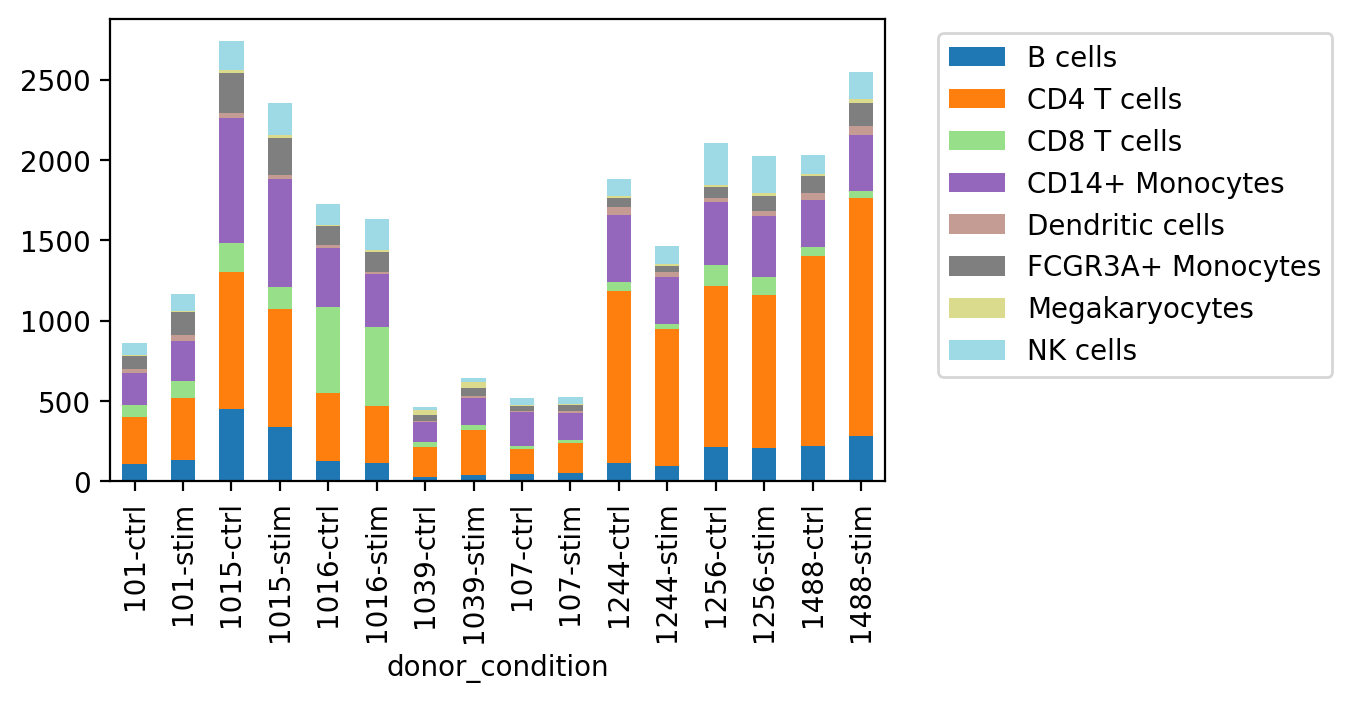

In [96]:
with plt.rc_context({'figure.figsize': (5, 3)}):
    pd.crosstab(adata.obs.donor_condition, adata.obs.cell).plot(kind='bar', stacked=True, cmap='tab20')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

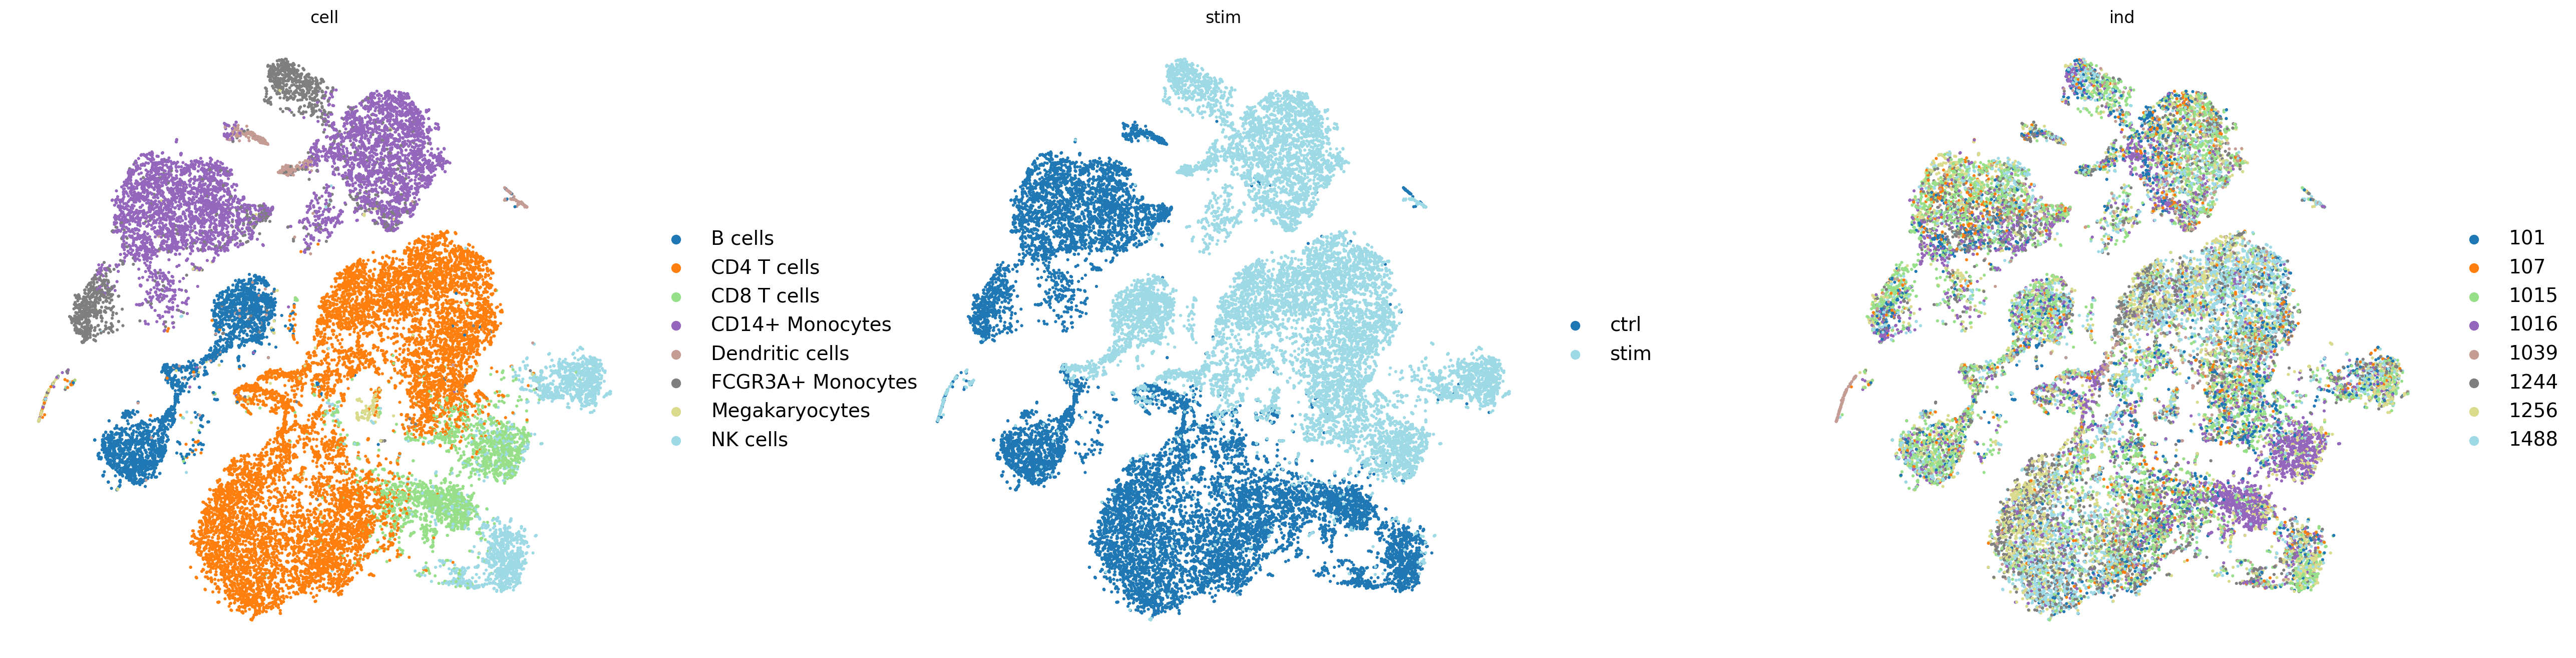

In [97]:
with warnings.catch_warnings() and plt.rc_context({'figure.figsize': (8, 8)}):
    warnings.simplefilter("ignore")
    sc.pl.tsne(
        adata, color=['cell', 'stim', 'ind'], wspace=0.3, add_outline=False, cmap='magma',size=20, palette='tab20',
        legend_fontsize=14, legend_fontoutline=2,frameon=False
    )

In [ ]:
adata.write_h5ad('data/ifn_adata.h5ad')

## 4. Tensorize Single Cell Data
Given a cell by gene matrix, wherein cells are annotated by cell type and donor, we create a pseudobulk tensor by aggregating the raw counts for each cell type, donor, and gene. The resulting pseudobulk data tensor has dimensions S x C × G, where S denotes the number of samples(donors), C the number of cell types and G the number of genes. 

We normalize the tensor such that each sample-cell type pair has a total of 1e5 counts. For the Poisson and Zero Inflated Poisson models we round the counts to the nearest integer to align with the support for the models. 

In order to facilitate biological interpretability of factors and reduce noise in the tensor formed we removed genes using the following to criteria:
- Filter out genes that we not provided with **HGNC** (HUGO Gene Nomenclature Committee) symbols 
- Filter out genes with less than **10** total count across all cells

We additionally filter out celltypes that constitute less than 2 percent of the whole dataset

In [3]:
adata = sc.read_h5ad('data/ifn_adata.h5ad')

In [4]:
celltype_threshold = 0.02
cell_types = adata.obs.cell.value_counts()[adata.obs.cell.value_counts()/adata.obs.cell.shape[0] > celltype_threshold]
rich.print(list(cell_types.index.values))

['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes']

In [5]:
sample_threshold = 0.02
low_samples = adata.obs.donor_condition.value_counts()/adata.obs.cell.shape[0] < celltype_threshold
low_samples = list(adata.obs.donor_condition.value_counts()[low_samples].index.values)
adata = adata[~adata.obs.ind.isin([s.split('-')[0] for s in low_samples])].copy()
adata.raw = adata.raw.to_adata()[~adata.raw.to_adata().obs.ind.isin([s.split('-')[0] for s in low_samples])].copy()
rich.print(adata.obs.ind.astype(str).unique())
rich.print(adata.raw.to_adata().obs.ind.astype(str).unique())

['1016' '1256' '1488' '1015' '107' '1244' '101']

['1016' '1256' '1488' '1015' '107' '1244' '101']

In [6]:
sc_tensor = SingleCellTensor.from_anndata(
    adata, sample_label='donor_condition', celltype_label='cell', cell_types = list(cell_types.index.values), 
    hgnc_approved_genes_only=True, normalize=True, filter_gene_count=50, scale_to=1e6
)
sc_tensor.tensor = sc_tensor.tensor.round()
rich.panel.Panel.fit(f"[bold green]Final tensor shape = {' x '.join([str(i) for i in sc_tensor.tensor.shape])} ", border_style="green")

Building tensor from matrix: 100%|██████████████| 14/14 [00:00<00:00, 73.76it/s]


╭─────────────────────────────────────╮
│ Final tensor shape = 14 x 6 x 9276  │
╰─────────────────────────────────────╯

## 5. Factorize Tensor using Variational Inference

We first factorize the tensor using a wide range of ranks (number of components) so as to identify the most fitting rank for this data. <br>
We use a small number of restarts (5) for this step

In [13]:
factorization_set = SingleCellBTF.factorize(
    sc_tensor = sc_tensor, 
    rank = range(2,15,3), 
    model = 'zero_inflated_poisson',
    n_restarts = 5, 
    num_steps = 2500,
    init_alpha = float(np.mean(sc_tensor.tensor[sc_tensor.tensor != 0])), 
    plot_var_explained = False
)

Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 2 matrices


100%|████████████████████████████████████████████| 5/5 [11:18<00:00, 135.65s/it]


Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 5 matrices


100%|████████████████████████████████████████████| 5/5 [12:37<00:00, 151.51s/it]


Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 8 matrices


100%|████████████████████████████████████████████| 5/5 [12:10<00:00, 146.18s/it]


Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 11 matrices


100%|████████████████████████████████████████████| 5/5 [15:23<00:00, 184.65s/it]


Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 14 matrices


100%|████████████████████████████████████████████| 5/5 [12:35<00:00, 151.03s/it]


In [30]:
factorization_set.save('results/full_factorization.pkl')

Saved SingleCellTensor object to path results/full_factorization.pkl


## 6. Construct Consensus Factorizations

The fact that the optimal CP factorization is non-unique, combined with randomness inherent in the factorization algorithm, results in factor sets that can substantially vary when the factorization is repeated multiple times, which makes interpretation challenging and difficult to trust.

To address this challenge, we borrow a meta-analysis method from matrix factorization called consensus-based factorization.
- M repeats of BTF are run using the same rank R resulting in M factor matrix sets {S, C, G}M . We concatenate all the gene factors together to form a G by R ⋅ M meta matrix. 
- The columns of the meta matrix are normalized column wise and clustered using K-Means with the same number of clusters R as the rank used for the BTF runs.
- We then retrieve a consensus gene factor matrix by taking the median of each cluster.
- Finally, the full factorization is recovered by running one last BTF run where the gene factor matrix is fixed to the consensus value, and we solve the non-negative tensor decomposition for the sample and cell type latent factor matrices. 

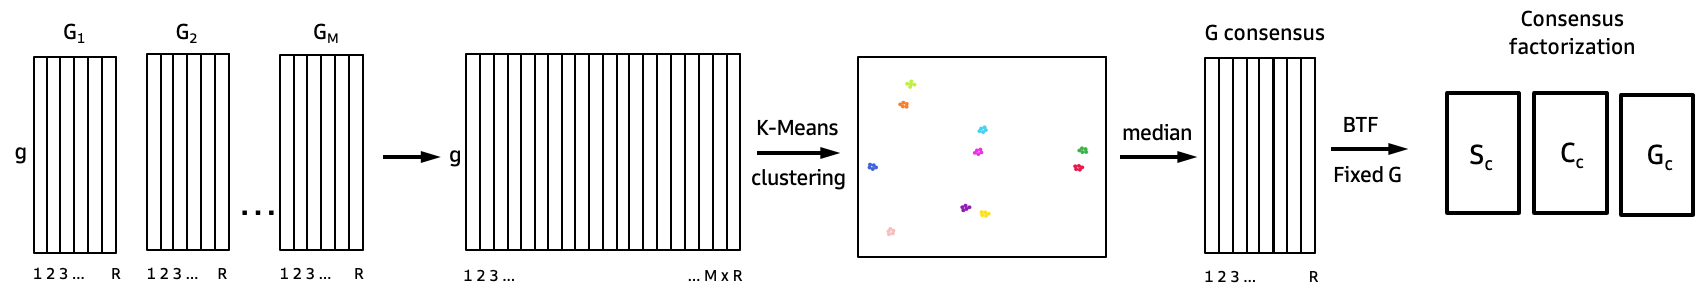

In [31]:
consensus = FactorizationSet()
consensus.sc_tensor = factorization_set.sc_tensor

for selected_rank in factorization_set.get_ranks():
    medians = factorization_set.reconstruct_factors_from_median_gene_factor(rank = selected_rank)
    reconstructed = SingleCellBTF.factorize(
        sc_tensor = factorization_set.sc_tensor, rank = selected_rank, n_restarts = 1, 
        init_alpha = float(np.mean(sc_tensor.tensor[sc_tensor.tensor != 0])), num_steps = 2500, 
        fixed_mode = 2, model = 'zero_inflated_poisson_fixed', fixed_value = torch.from_numpy(medians.T).float(), 
        plot_var_explained = False
    )

    gene_factor = reconstructed.get_factorization(rank = selected_rank, restart_index = 0).gene_factor['mean'].numpy()
    mismatch = (1 - np.isclose(medians.T, gene_factor, atol=0.5)).sum()
    var_explained = reconstructed.variance_explained(rank=selected_rank, restart_index=0).item()
    print(f'{mismatch} / {medians.flatten().shape[0]} mismatches in final gene factors')
    print(f'Variance explained by reconstructed factorization = {var_explained}')
    consensus.factorizations[selected_rank] = reconstructed.factorizations[selected_rank]
consensus.save('results/consensus_factorization.pkl')

Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 2 matrices


100%|████████████████████████████████████████████| 1/1 [01:48<00:00, 108.77s/it]


101 / 18552 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.8438692688941956
Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 5 matrices


100%|████████████████████████████████████████████| 1/1 [01:51<00:00, 111.86s/it]


228 / 46380 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.9187996983528137
Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 8 matrices


100%|████████████████████████████████████████████| 1/1 [01:57<00:00, 117.15s/it]


409 / 74208 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.9204041957855225
Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 11 matrices


100%|████████████████████████████████████████████| 1/1 [02:00<00:00, 120.72s/it]


462 / 102036 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.9384199380874634
Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 14 matrices


100%|████████████████████████████████████████████| 1/1 [02:07<00:00, 127.01s/it]

601 / 129864 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.9106605052947998
Saved SingleCellTensor object to path results/consensus_factorization.pkl


## 7. Visualize Results of Factorization 

Main goal here is to determine the appropriate rank. <br>
Use a combination of fit and stability metrics such as explained variance and silhouette score and a biologically minded assessment of the factorization results to determine the appropriate rank.

In [32]:
full_factorization = FactorizationSet.load('results/full_factorization.pkl')
consensus_factorization = FactorizationSet.load('results/consensus_factorization.pkl')

In [ ]:
children = []
for rank in sorted(list(full_factorization.get_ranks())):
    out = widgets.Output()
    with out:
        fig, ax = plt.subplots(figsize=(5, 2))
        n_restarts = len(full_factorization.factorizations[rank])
        var_explained = [full_factorization.variance_explained(rank=rank, restart_index=i) for i in range(n_restarts)]
        ax.plot(var_explained, 'g')
        plt.xlabel('Restart')
        plt.ylabel("Variance Explained")
        plt.ylim(min(var_explained) - 0.05, 1)
        plt.show(fig)
    children.append(out)
tab = widgets.Tab(children = children)
for index, rank in enumerate(sorted(list(full_factorization.get_ranks()))):
    tab.set_title(index, f'Rank {rank}')
tab

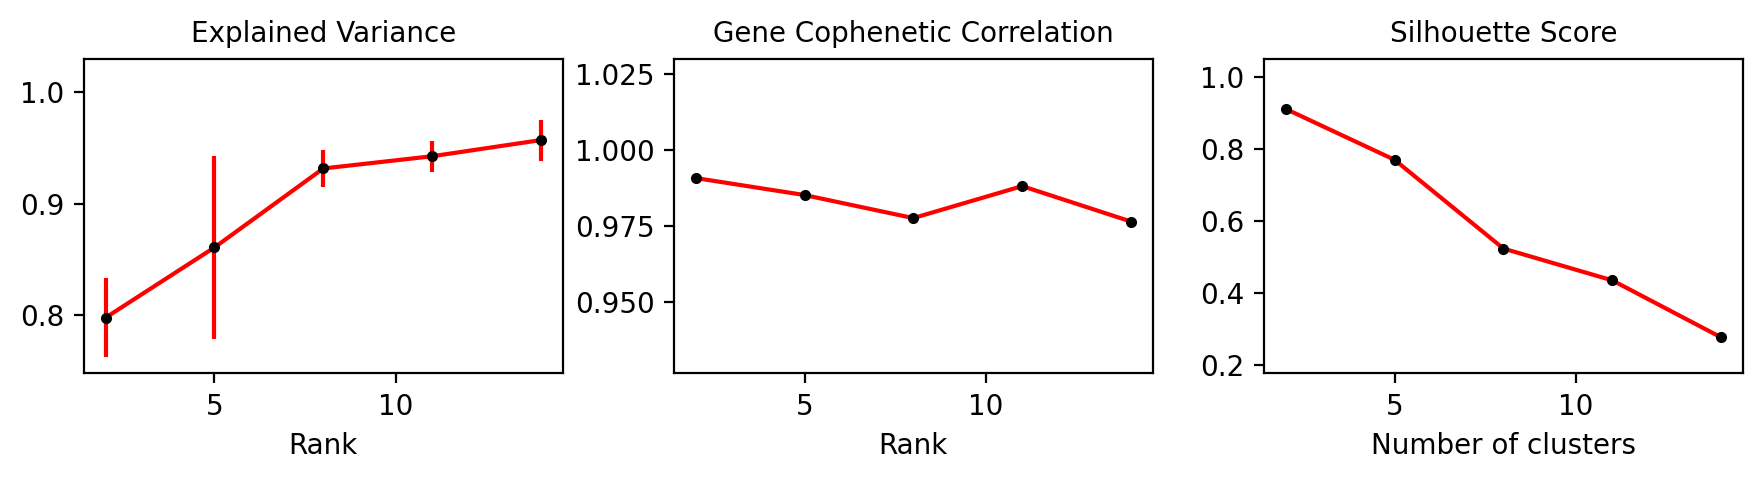

In [75]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = full_factorization.rank_metrics_plot(force=True, entropy=2, eps=1)

In [77]:
fig.savefig(f"results/ifnb_rank_metrics_plot.pdf", dpi=300, bbox_inches="tight")

<div class="alert alert-block alert-info">
<b>Note:</b> The first panel in these figures gives the Factor loadings for samples ordered by the sample_grouping_column (_stim_ here) and the second panel gives Factor loadings for celltypes. The third panel gives the gene program extracted from the gene loadings of the factor.
</div>


In [76]:
children = []
for rank in sorted(list(consensus_factorization.get_ranks())):
    out = widgets.Output()
    with out:
        fig = consensus_factorization.plot_components(
            rank=rank, restart_index=0, threshold = 0.7, entropy = 1, eps = 0, sort_by = 'other',
            sample_grouping_column='stim', title = False,
            plot_erichment_terms=False, normalize_gene_factors=True
        )
        plt.show(fig)
    children.append(out)
tab = widgets.Tab(children = children)
for index, rank in enumerate(sorted(list(consensus_factorization.get_ranks()))):
    tab.set_title(index, f'Rank {rank}')
display(tab)

## 8. Rerun Routine with more restarts for selected Rank 

In [36]:
selected_rank = 8

In [ ]:
factorization_set = SingleCellBTF.factorize(
    sc_tensor = sc_tensor, 
    rank = selected_rank, 
    model = 'zero_inflated_poisson',
    n_restarts = 50, 
    num_steps = 2500,
    init_alpha = float(np.mean(sc_tensor.tensor[sc_tensor.tensor != 0])), 
    plot_var_explained = False
)
factorization_set.save('results/selected_rank_full_factorization.pkl')

Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 8 matrices


 90%|████████████████████████████████████    | 45/50 [1:38:25<10:58, 131.66s/it]

In [81]:
# generate consensus factorization
medians = factorization_set.reconstruct_factors_from_median_gene_factor(rank = selected_rank)
consensus = SingleCellBTF.factorize(
    sc_tensor = factorization_set.sc_tensor, rank = selected_rank, n_restarts = 1, 
    init_alpha = float(np.mean(sc_tensor.tensor[sc_tensor.tensor != 0])), num_steps = 2500, 
    fixed_mode = 2, model = 'zero_inflated_poisson_fixed', fixed_value = torch.from_numpy(medians.T).float(), 
    plot_var_explained = False
)

gene_factor = consensus.get_factorization(rank = selected_rank, restart_index = 0).gene_factor['mean'].numpy()
mismatch = (1 - np.isclose(medians.T, gene_factor, atol=2)).sum()
var_explained = consensus.variance_explained(rank=selected_rank, restart_index=0).item()
print(f'{mismatch} / {medians.flatten().shape[0]} mismatches in final gene factors')
print(f'Variance explained by reconstructed factorization = {var_explained}')
consensus.save('results/selected_rank_consensus_factorization.pkl')

Decomposing tensor of shape torch.Size([14, 6, 9276]) into rank 8 matrices


100%|████████████████████████████████████████████| 1/1 [01:57<00:00, 117.94s/it]


14 / 74208 mismatches in final gene factors
Variance explained by reconstructed factorization = 0.8645024299621582
Saved SingleCellTensor object to path results/selected_rank_consensus_factorization.pkl


In [82]:
fig = consensus.plot_components(
    rank=selected_rank, restart_index=0, threshold = 0.4, entropy = 1, eps = 1, sort_by = 'other',
    sample_grouping_column='stim', title = False, plot_erichment_terms=False, normalize_gene_factors=True
)

In [70]:
fig.savefig(f"results/ifnb_all_factors.pdf", dpi=300, bbox_inches="tight")